In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from mst_prim import prim_mst
from nemo import evaluate_nemo
import util
from util import lighten_color
from util import centroid_label, coordinator_label, worker_label, ccolor, cmarker
from topology import get_lognorm_hist, setup_topology, get_lognorm_samples, add_cluster_labels
import topology

plt.rcParams.update({'font.size': 12})

#### Topology Setup

In [3]:
seed = 4
np.random.seed(seed)

device_number = 1000 + 1
avg = 50
c_capacity = 50
max_resources = device_number * avg - c_capacity

X_dim_range = [0, 100]
Y_dim_range = [-50, 50]
centers = 40

H, bins = get_lognorm_hist()
coords_df = topology.coords_sim(1000, centers, X_dim_range, Y_dim_range, seed)

coord_dict = {}
coord_dict = topology.get_coords_dict() # uncomment for the other topologies
coord_dict["sim(1000)"] = coords_df
df_dict_topologies = topology.create_topologies_from_dict(coord_dict, H, max_resources, c_capacity,
                                                          weights=(1, avg * 2), dist="lognorm", with_clustering=True,
                                                          kmin=2, kmax=30, kseed=10)

Creating df for planetlab
Optimal k is 3
Creating df for king
Optimal k is 6
Creating df for fit
Optimal k is 3
Creating df for sim(1000)
Optimal k is 21
Done


In [4]:
t_label = "sim(1000)"
prim_df, c_coords, base_col, slot_columns, centroids, opt_k, sil = df_dict_topologies[t_label]
coords = prim_df[["x", "y"]].to_numpy()
prim_df["weight_1"] = 1
prim_df["weight_2"] = 2

eval_matrix = {}
prim_df

,x,y,latency,type,base,weight,capacity_100,capacity_90,capacity_80,capacity_70,...,capacity_50,capacity_40,capacity_30,capacity_20,capacity_10,capacity_5,capacity_1,cluster,weight_1,weight_2
0,19.383905,7.406120,0.000000,coordinator,9223372036854775807,0,50,50,50,50,...,50,50,50,50,50,50,50,-1,1,2
1,67.743232,-14.007158,52.888118,worker,9223372036854775807,14,50,51,46,46,...,45,55,43,30,19,70,0,3,1,2
2,5.220579,-15.467092,26.903228,worker,9223372036854775807,1,50,53,51,50,...,53,39,49,26,23,16,65,8,1,2
3,43.521014,41.129903,41.471599,worker,9223372036854775807,1,50,53,57,45,...,58,63,81,26,30,163,47,14,1,2
4,14.195029,1.412734,7.927491,worker,9223372036854775807,1,50,53,47,43,...,58,69,88,33,92,34,8,19,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,14.908514,-3.352142,11.652010,worker,9223372036854775807,1,50,52,47,56,...,70,58,65,38,21,55,261,19,1,2
997,39.672067,34.499402,33.847532,worker,9223372036854775807,3,50,53,51,55,...,43,43,68,26,26,11,33,14,1,2
998,40.609309,23.985392,26.933066,worker,9223372036854775807,1,50,53,54,45,...,37,79,41,120,21,24,4,6,1,2
999,31.878351,34.859971,30.163307,worker,9223372036854775807,2,50,52,50,46,...,38,63,83,24,35,39,139,2,1,2


In [5]:
print("Required:", prim_df["weight"].sum(), "Available:", prim_df["capacity_100"].sum())

Required: 6746 Available: 50050


In [6]:
colors, light_colors, palette = util.get_color_list(opt_k)
palette

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)]

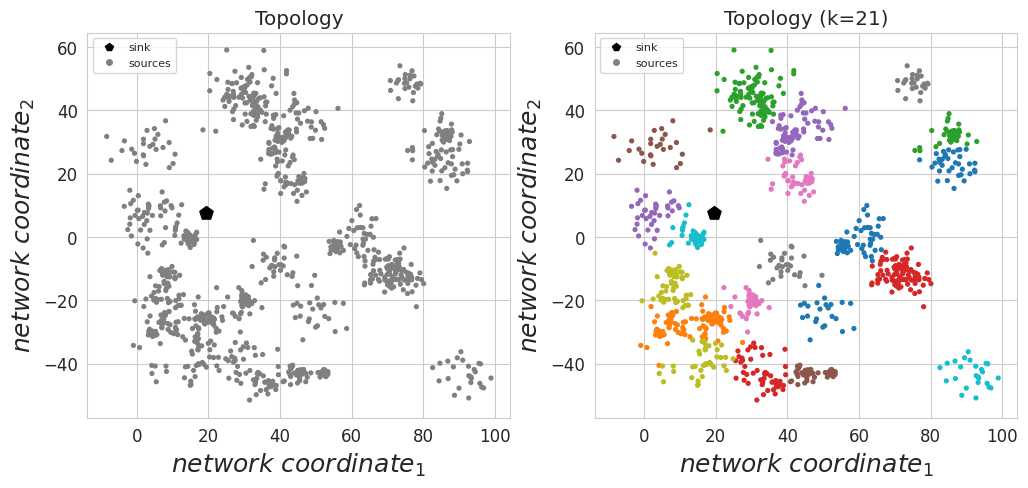

In [7]:
X_dim_def = [-50, 50]
Y_dim_def = [-60, 60]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
util.plot_topology(ax1, prim_df)
util.plot_topology(ax2, prim_df, colors, 'Topology (k=' + str(opt_k) + ")")

#ax1.set_xlim(X_dim_def)
#ax2.set_xlim(X_dim_def)

#ax1.set_ylim(Y_dim_def)
#ax2.set_ylim(Y_dim_def)

X_dim = ax1.get_xlim()
Y_dim = ax1.get_ylim()

plt.show()

### Experiment 2b: NEMO Aggregation with Density-based Grouping

In [23]:
# fixed params
max_levels = 50
slot_col = "capacity_100"
weight_col = "weight_1"

# dynamic params
num_points = 9
start = 0.1
end = 0.9
hyperparam_values_1 = np.linspace(start, end, num_points)
hyperparam_values_2 = np.linspace(start, end, num_points)
X, Y = np.meshgrid(hyperparam_values_1, hyperparam_values_2)

# Initialize an array to store performance values
perc_lat_values = np.zeros_like(X)
mean_lat_values = np.zeros_like(X)

for i in range(num_points):
    for j in range(num_points):
        eval_dict, df_dict, opt_dict, limits_dict = evaluate_nemo(prim_df, [slot_col], weight_col, merge_factor=X[i, j], step_size=Y[i, j], max_levels=max_levels, with_eval=True)
        sv = eval_dict[slot_col]["latency_distribution"].sort_values()
        perc_lat = round(sv.quantile(0.9), 2)
        mean_lat = round(sv.mean(), 2)
        print(perc_lat, mean_lat)

        perc_lat_values[i, j] = perc_lat
        mean_lat_values[i, j] = mean_lat

Starting nemo for: c=capacity_100, w=weight_1, l=50, step_size=0.1, merge_factor=0.1
Evaluating for capacity_100
74.55 57.54
Starting nemo for: c=capacity_100, w=weight_1, l=50, step_size=0.1, merge_factor=0.2
Evaluating for capacity_100
85.58 64.39
Starting nemo for: c=capacity_100, w=weight_1, l=50, step_size=0.1, merge_factor=0.30000000000000004
Evaluating for capacity_100
86.33 66.99
Starting nemo for: c=capacity_100, w=weight_1, l=50, step_size=0.1, merge_factor=0.4
Evaluating for capacity_100
85.49 67.6
Starting nemo for: c=capacity_100, w=weight_1, l=50, step_size=0.1, merge_factor=0.5
Evaluating for capacity_100
72.05 53.6
Starting nemo for: c=capacity_100, w=weight_1, l=50, step_size=0.1, merge_factor=0.6
Evaluating for capacity_100
77.96 61.32
Starting nemo for: c=capacity_100, w=weight_1, l=50, step_size=0.1, merge_factor=0.7000000000000001
Evaluating for capacity_100
75.62 57.45
Starting nemo for: c=capacity_100, w=weight_1, l=50, step_size=0.1, merge_factor=0.8
Evaluating 

merge factor and step size for minimum latency (90P): (X=0.4, Y=0.2) 69.81
merge factor and step size for minimum latency (mean): (X=0.9, Y=0.2) 44.27


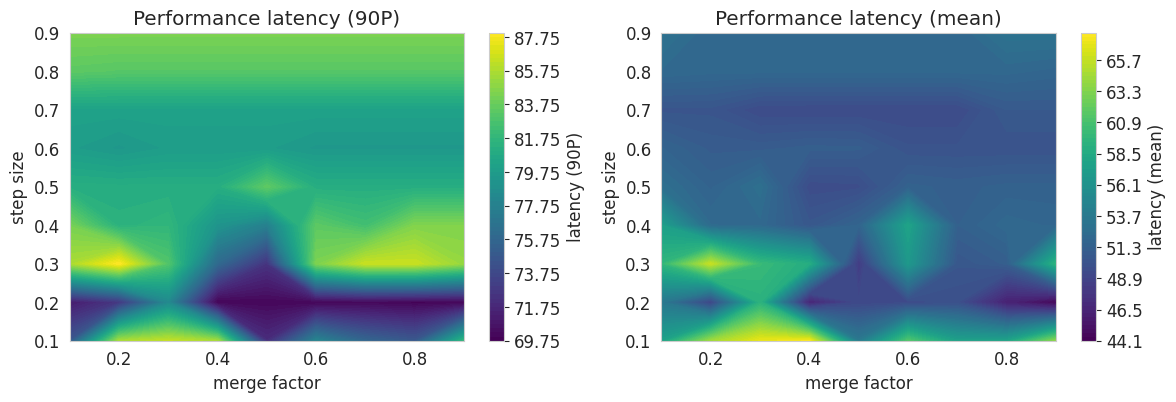

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(14, 4))

for i, values in enumerate([perc_lat_values, mean_lat_values]):
    if i == 0:
        label = "latency (90P)"
    elif i == 1:
        label = "latency (mean)"
    else:
        label = "undefined"
        
    # Find the indices of the minimum Z value
    min_index = np.unravel_index(np.argmin(values), values.shape)
    # Use the indices to get the corresponding X and Y values
    min_X = X[min_index]
    min_Y = Y[min_index]
    print(f"merge factor and step size for minimum {label}: (X={min_X}, Y={min_Y})", values[min_index])
    
    # Create a contour plot
    ax = axs[i]
    contour = ax.contourf(X, Y, values, levels=80, cmap='viridis')

    # Create a colorbar and set the label
    colorbar = plt.colorbar(contour)
    colorbar.set_label(label)
    
    ax.set_title(f"Performance {label}")
    ax.set_xlabel('merge factor')
    ax.set_ylabel('step size')
    
plt.show()

In [30]:
# assign nodes to previous clustering alg
max_levels = 50
merge_factor = 0.4 # weight_1 0.4, weight 0.9
step_size = 0.2 # weight_1 0.2, weight 0.3

slot_col = "capacity_100"
weight_col = "weight_1"
eval_name = "nemo" + "_" + weight_col

df_dict_1, opt_dict_1, limits_dict_1 = evaluate_nemo(prim_df, [slot_col], weight_col, step_size=step_size, merge_factor=merge_factor, max_levels=1, with_eval=False)
eval_matrix[eval_name], df_dict, opt_dict, limits_dict = evaluate_nemo(prim_df, [slot_col], weight_col, step_size=step_size, merge_factor=merge_factor, max_levels=max_levels, with_eval=True)

Starting nemo for: c=capacity_100, w=weight_1, l=1, step_size=0.2, merge_factor=0.4
Starting nemo for: c=capacity_100, w=weight_1, l=50, step_size=0.2, merge_factor=0.4
Evaluating for capacity_100


In [31]:
eval_matrix.keys()

dict_keys(['nemo_weight', 'nemo_weight_1'])

In [32]:
df = df_dict[slot_col]
df

,oindex,x,y,type,cluster,total_weight,used_weight,total_capacity,free_capacity,level,parent,latency,load
0,0,19.383905,7.406120,coordinator,-1,0,0,50,49,5,0,0.000000,1
1,1,67.743232,-14.007158,worker,3,14,1,50,50,0,194,64.218135,0
2,2,5.220579,-15.467092,worker,8,1,1,50,50,0,132,53.518560,0
3,3,43.521014,41.129903,worker,14,1,1,50,50,0,58,60.809550,0
4,4,14.195029,1.412734,worker,19,1,1,50,16,1,149,67.036899,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,996,14.908514,-3.352142,worker,19,1,1,50,50,0,4,71.854898,0
997,997,39.672067,34.499402,worker,14,3,1,50,50,0,58,53.262927,0
998,998,40.609309,23.985392,worker,6,1,1,50,50,0,238,56.883588,0
999,999,31.878351,34.859971,worker,2,2,1,50,50,0,652,56.233740,0


In [33]:
df[df["parent"] == df["oindex"]]

,oindex,x,y,type,cluster,total_weight,used_weight,total_capacity,free_capacity,level,parent,latency,load
0,0,19.383905,7.40612,coordinator,-1,0,0,50,49,5,0,0.0,1


In [34]:
df[df["parent"] == 0]

,oindex,x,y,type,cluster,total_weight,used_weight,total_capacity,free_capacity,level,parent,latency,load
0,0,19.383905,7.406120,coordinator,-1,0,0,50,49,5,0,0.00000,1
71,71,32.543847,-1.122257,worker,7,1,1,50,47,4,0,15.68175,3


In [35]:
# check -> should be empty
df_overloaded = df.groupby(['parent'])['used_weight'].sum().copy().reset_index()
df_join = df[["oindex", "total_capacity", "free_capacity"]]
result = pd.merge(df_join, df_overloaded, left_on='oindex', right_on='parent', how='inner')
result["delta"] = result["total_capacity"] - result["used_weight"]
result[result["delta"] < 0]

,oindex,total_capacity,free_capacity,parent,used_weight,delta


In [36]:
# check -> should be empty
result[result["delta"] != result["free_capacity"]]

,oindex,total_capacity,free_capacity,parent,used_weight,delta


In [37]:
result

,oindex,total_capacity,free_capacity,parent,used_weight,delta
0,0,50,49,0,1,49
1,4,50,16,4,34,16
2,6,50,39,6,11,39
3,25,50,26,25,24,26
4,58,50,2,58,48,2
5,71,50,47,71,3,47
6,105,50,47,105,3,47
7,129,50,14,129,36,14
8,132,50,4,132,46,4
9,149,50,47,149,3,47


In [38]:
#create greedy aggregation tree
cluster_coords = centroids
cluster_coords_with_crd = np.column_stack((c_coords, cluster_coords.T)).T

mst = prim_mst(cluster_coords_with_crd)

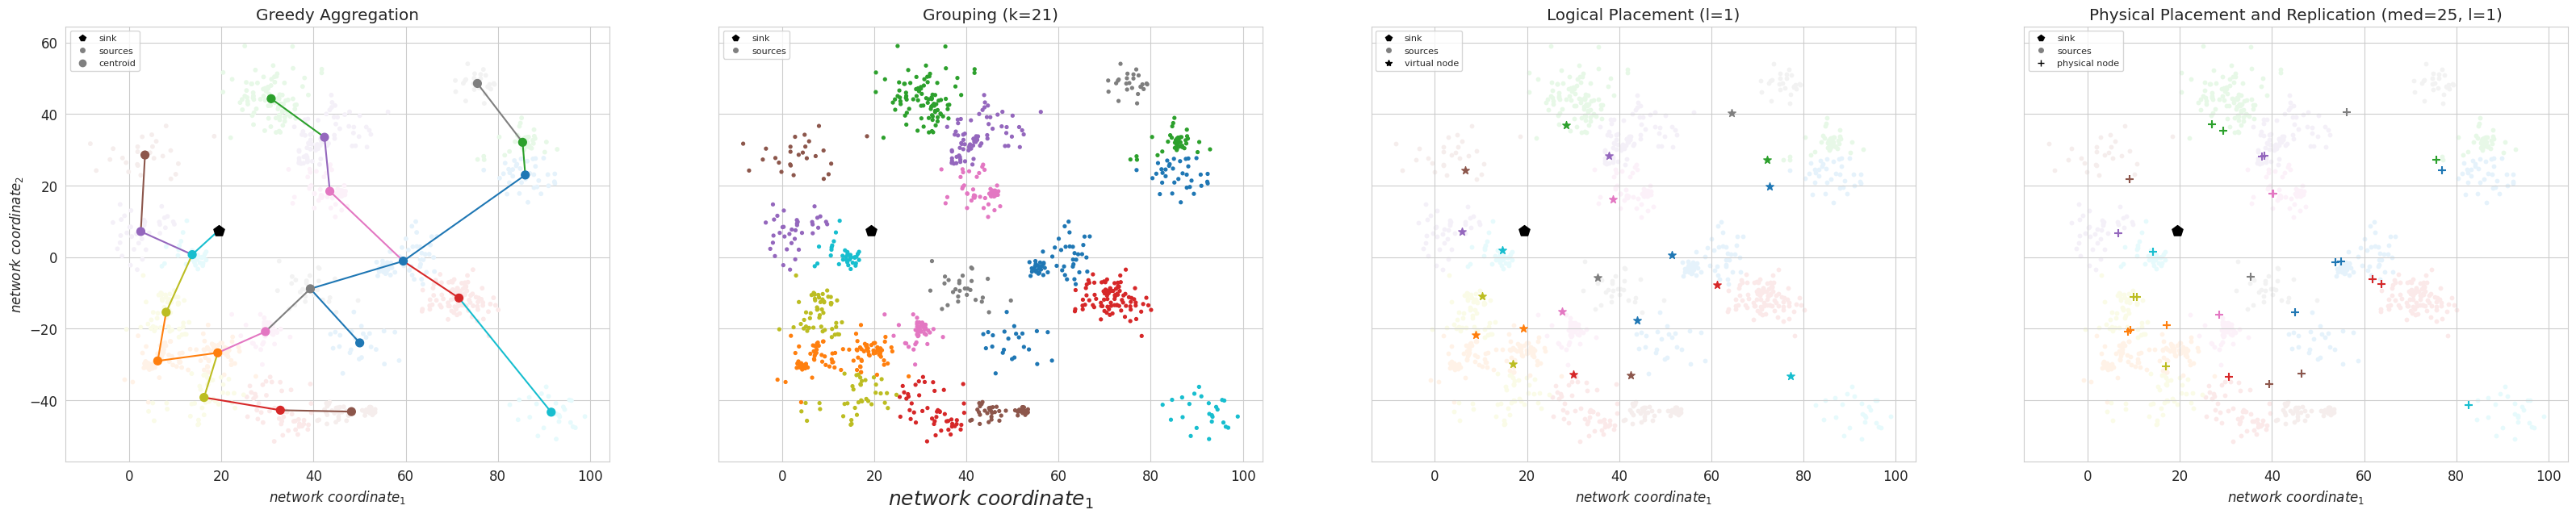

In [39]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(40, 7), sharex="all", sharey="all")
lval = 0.1
labels = prim_df["cluster"]

# plot greedy approach from MST
for i in range(1, len(mst)):
    point1 = cluster_coords_with_crd[i]
    point2 = cluster_coords_with_crd[mst[i]]
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    ax1.plot(x_values, y_values, zorder=2, color=colors[i - 1])

ax1.scatter(coords[0, 0], coords[0, 1], s=100, color=ccolor, marker=cmarker, zorder=10)
ax1.scatter(cluster_coords[:, 0], cluster_coords[:, 1], s=50, color=colors[:len(cluster_coords)], zorder=3)
# in case all coords shall be plotted
ax1.scatter(coords[:, 0], coords[:, 1], s=10, color=[lighten_color(x, lval) for x in colors[labels]])

lcentroid = Line2D([], [], color="blue", marker='o', linestyle='None', label='centroid')
ax1.legend(handles=[coordinator_label, worker_label, centroid_label], loc="upper left", bbox_to_anchor=(0, 1),
           fontsize=8)

ax1.set_xlabel('$network$ $coordinate_1$')
ax1.set_ylabel('$network$ $coordinate_2$')
ax1.set_title('Greedy Aggregation')

#plot grouping
util.plot_topology(ax2, prim_df, colors, title='Grouping (k=' + str(opt_k) + ")")

#plot logical nodes (optima) of different groups
# util.plot2(ax3, prim_df, df_dict[slot_col], colors, lval=lval, show_centroids=True)
util.plot_optimum(ax3, prim_df, opt_dict_1[slot_col], colors, lval=lval, plot_centroid=False, plot_lines=False)

# plot physical nodes
util.plot(ax4, prim_df, df_dict_1[slot_col], colors, lval=lval, plot_centroids=False, plot_lines=False)

#plt.xlim(X_dim)
#plt.ylim(Y_dim)
ax3.set_title("Logical Placement (l=1)")
ax4.set_title("Physical Placement and Replication (med=" + str(25) + ", l=1)")

#plt.savefig("plots/sim_1000/nemo_phases.svg", bbox_inches="tight")
plt.show()

Starting nemo for: c=capacity_100, w=weight_1, l=1, step_size=0.2, merge_factor=0.4
Starting nemo for: c=capacity_100, w=weight_1, l=2, step_size=0.2, merge_factor=0.4
Starting nemo for: c=capacity_100, w=weight_1, l=5, step_size=0.2, merge_factor=0.4
Starting nemo for: c=capacity_100, w=weight_1, l=20, step_size=0.2, merge_factor=0.4


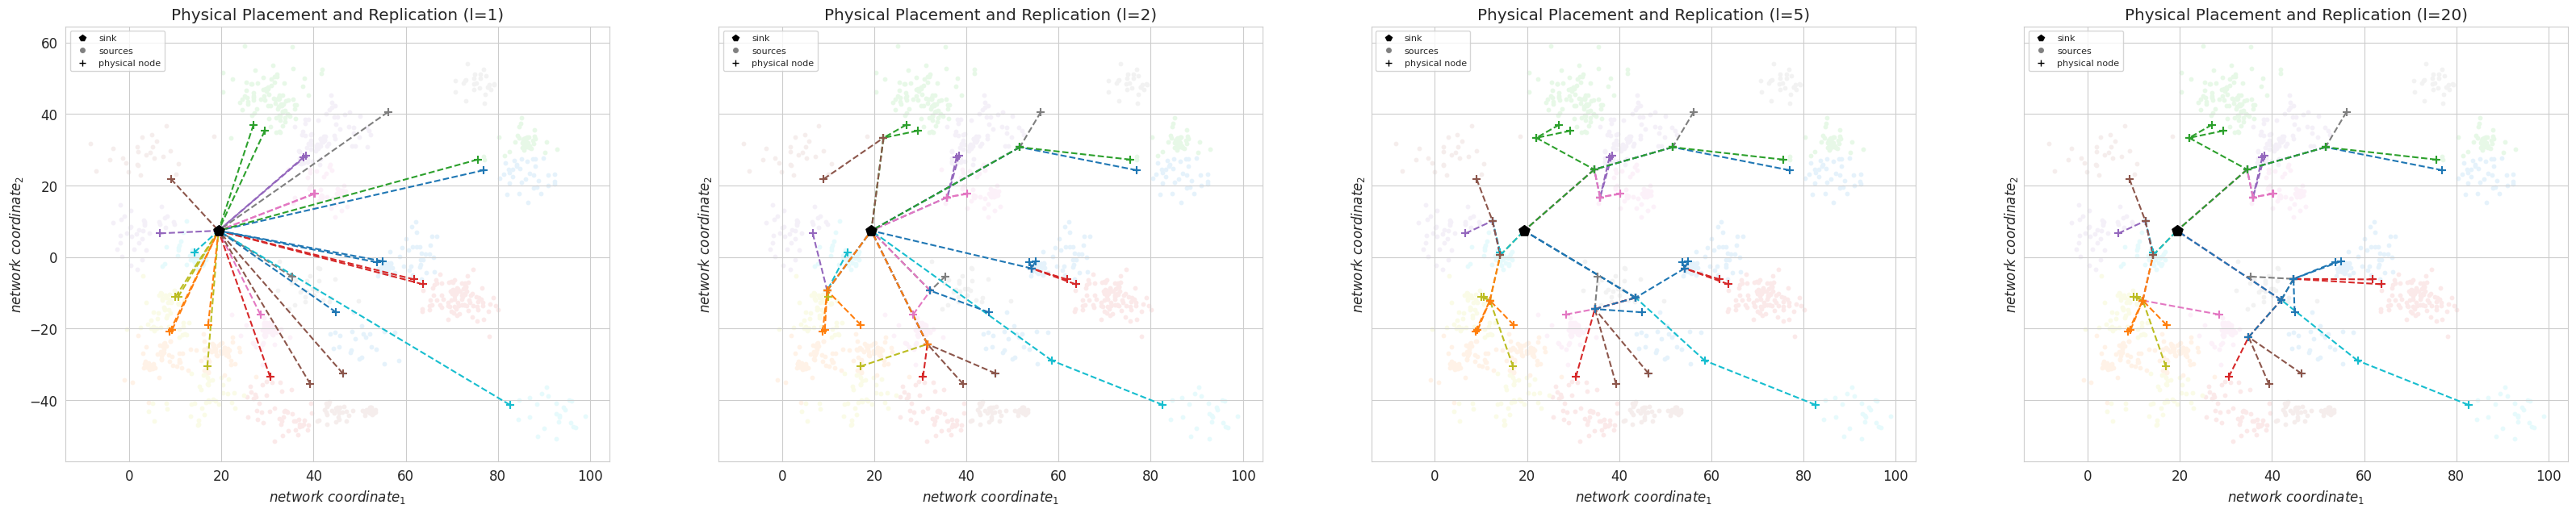

In [40]:
levels = [1, 2, 5, 20]

fig, axs = plt.subplots(1, 4, figsize=(40, 7), sharex="all", sharey="all")
lval = 0.1

for i, level in enumerate(levels):
    df_dict_i, opt_dict_i, limits_dict_i = evaluate_nemo(prim_df, [slot_col], weight_col, step_size=step_size, merge_factor=merge_factor, max_levels=level, with_eval=False)
    util.plot(axs[i], prim_df, df_dict_i[slot_col], colors, lval=lval, plot_centroids=False, plot_lines=True)
    axs[i].set_title("Physical Placement and Replication (l=" + str(level) + ")")

plt.show()

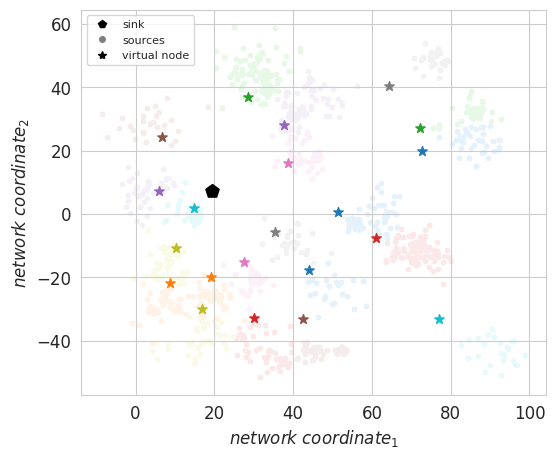

In [41]:
fig = plt.figure(figsize=(6, 5)).gca()

#uncomment this to plot nemo grouping
#ax2.scatter(coords[:, 0], coords[:, 1], s=10, color=[lighten_color(x, 0.2) for x in colors[labels]], zorder=-1)
#ax2.scatter(cluster_coords[:, 0], cluster_coords[:, 1], s=50, color=colors[:no_clusters], zorder=2)
#ax2.scatter(coords[0, 0], coords[0, 1], s=100, color=ccolor, marker=cmarker, zorder=1)
#ax2.set_title('Grouping (k=' + str(opt_k) + ")")
#fig.legend(handles=[coordinator_label, worker_label, centroid_label], loc="upper left", bbox_to_anchor=(0, 1), fontsize=8)

#uncomment this for nemo placement
util.plot_optimum(fig, prim_df, opt_dict[slot_col], colors, lval=lval, plot_centroid=False, plot_lines=False)

#uncomment this for nemo redistribution
#util.plot(fig, new_paths_flat[slot_col], agg_dict_flat[slot_col], c_coords, cluster_coords, coords, colors, labels, changed_labels=reassigned_clussters, lval=lval)


fig.set_xlabel('$network$ $coordinate_1$')
fig.set_ylabel('$network$ $coordinate_2$')

#plt.savefig("plots/sim_1000/nemo_placement.svg", bbox_inches="tight")
plt.show()

## Evaluation

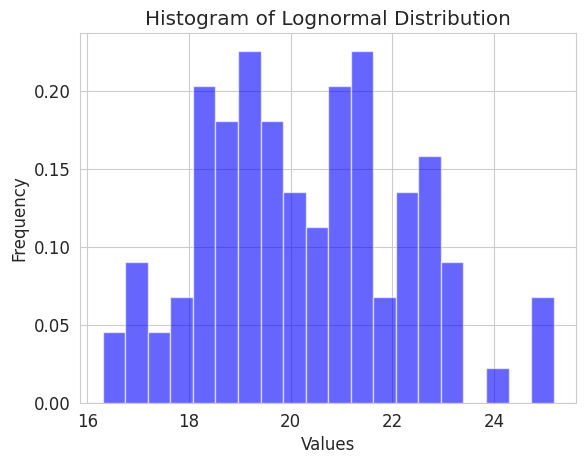

In [46]:
# Set the parameters
mean = 3.0  # Mean of the lognormal distribution
sigma = 0.1  # Standard deviation of the lognormal distribution
length = 100  # Desired length of the list

# Generate random values from a lognormal distribution
random_values = np.random.lognormal(mean, sigma, length)

# Plot a histogram of the random values
plt.hist(random_values, bins=20, density=True, alpha=0.6, color='b')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of Lognormal Distribution')
plt.grid(True)

# Show the plot
plt.show()

In [47]:
start = 0.0
stop = 100
step = .2
values_topo = {}
slot_col = "capacity_100"

for t_label in df_dict_topologies.keys():
    print("Starting for topology", t_label)
    df, c_coords, base_col, slot_columns, centroids, opt_k, sil = df_dict_topologies[t_label]
    values = {}
    size = df.shape[0]
    current_mu = start
    while current_mu < stop:
        print(current_mu)
        out = get_lognorm_samples(1, avg * 2, size, mu=current_mu, sigma=1)
        df["weight"] = out
        df_dict, opt_dict, limits_dict = evaluate_nemo(df, [slot_col], "weight", step_size=step_size, merge_factor=merge_factor, with_eval=False)
        if limits_dict[slot_col]:
            break
        
        levels = df_dict[slot_col].loc[0, "level"]
        cluster_heads = df_dict[slot_col]["parent"].nunique()
        ch_rel = cluster_heads / size
        values[current_mu] = (np.mean(out), np.median(out), np.max(out), levels, cluster_heads, ch_rel)
        current_mu += step

    values_topo[t_label] = values

print("Done")

Starting for topology planetlab
0.0
Starting nemo for: c=capacity_100, w=weight, l=20, step_size=0.2, merge_factor=0.4
0.2
Starting nemo for: c=capacity_100, w=weight, l=20, step_size=0.2, merge_factor=0.4
0.4
Starting nemo for: c=capacity_100, w=weight, l=20, step_size=0.2, merge_factor=0.4
0.6000000000000001
Starting nemo for: c=capacity_100, w=weight, l=20, step_size=0.2, merge_factor=0.4
0.8
Starting nemo for: c=capacity_100, w=weight, l=20, step_size=0.2, merge_factor=0.4
1.0
Starting nemo for: c=capacity_100, w=weight, l=20, step_size=0.2, merge_factor=0.4
1.2
Starting nemo for: c=capacity_100, w=weight, l=20, step_size=0.2, merge_factor=0.4
1.4
Starting nemo for: c=capacity_100, w=weight, l=20, step_size=0.2, merge_factor=0.4
1.5999999999999999
Starting nemo for: c=capacity_100, w=weight, l=20, step_size=0.2, merge_factor=0.4
1.7999999999999998
Starting nemo for: c=capacity_100, w=weight, l=20, step_size=0.2, merge_factor=0.4
1.9999999999999998
Starting nemo for: c=capacity_100,

In [48]:
plot_topo = {
    "sim(1000)": {"color": "blue", "marker": "s"},
    "fit": {"color": "purple", "marker": "D"},
    "planetlab": {"color": "gold", "marker": "v"},
    "king": {"color": "teal", "marker": "p"}
}

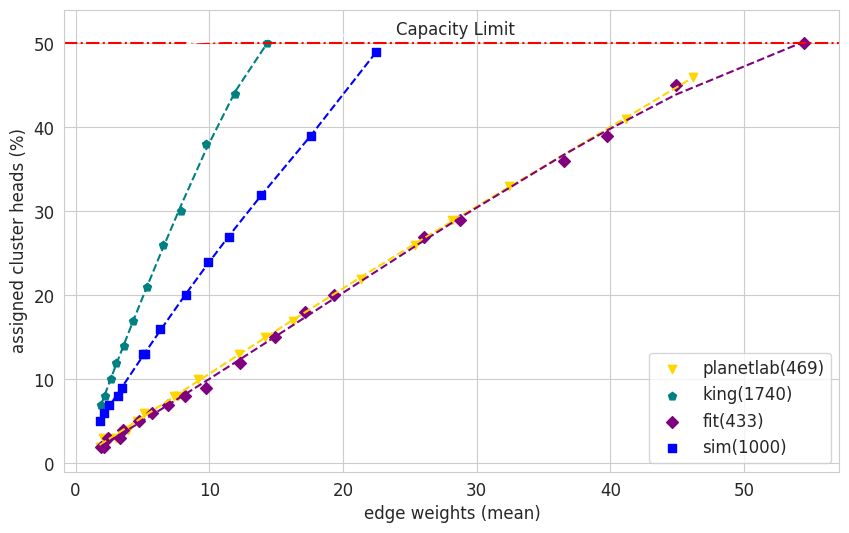

In [52]:
# Specify the figure size (e.g., 8x6 inches)
fig, ax = plt.subplots(figsize=(10, 6))

for k in values_topo.keys():
    data_dict = values_topo[k]
    
    # Extract the keys and values from the dictionary
    keys = list(data_dict.keys())
    x_values = [round(item[0], 2) for item in data_dict.values()]
    y_values = [round(item[5], 2) * 100 for item in data_dict.values()]
    
    c = plot_topo[k]["color"]
    m = plot_topo[k]["marker"]
    
    # Create the main plot
    if k != "sim(1000)":
        k = k + "(" + str(df_dict_topologies[k][0].shape[0]) + ")"
    ax.scatter(x_values, y_values, marker=m, color=c, label=k)
    
    # Calculate the regression line
    coefficients = np.polyfit(x_values, y_values, 4)
    regression_line = np.polyval(coefficients, x_values)
    
    # Plot the regression line
    ax.plot(x_values, regression_line, "--", color=c)

# Add the vertical dashed line at x=8
#vertical_line_x = 8.5
#ax.axvline(x=vertical_line_x, color='r', linestyle='--')

# Add an annotation at the vertical line
#annotation_x = 8.7
#annotation_y = 320
#ax.annotate('resource \nlimit', xy=(vertical_line_x, annotation_y), xytext=(annotation_x, annotation_y),
#            arrowprops=dict(arrowstyle='->'))

# Add the horizontal dashed line at y=320
horizontal_line_y = 50
ax.axhline(y=horizontal_line_y, color='red', linestyle='-.')

# Add an annotation at the horizontal line
annotation_x = 24  # X-coordinate of the annotation
annotation_y = 51  # Y-coordinate of the annotation
ax.annotate('Capacity Limit', xy=(8, horizontal_line_y), xytext=(annotation_x, annotation_y),
            arrowprops=dict(arrowstyle='->'))

# Set axis labels and title for the main plot
ax.set_xlabel('edge weights (mean)')
ax.set_ylabel('assigned cluster heads (%)')

ax.set_ylim([-1, 54])

# Create a legend for the scatter plot with a label
legend = ax.legend()
# legend.set_title("Topology")

# Display the plot
plt.show()